In [58]:
import numpy as np
#import modin.pandas as pd
import pandas as pd
from ppca import PPCA
import six

import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, Birch, FeatureAgglomeration, SpectralClustering, SpectralCoclustering, SpectralBiclustering, DBSCAN, AffinityPropagation, MeanShift
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA, FastICA, IncrementalPCA, KernelPCA, FactorAnalysis, TruncatedSVD, SparsePCA, MiniBatchSparsePCA, DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.manifold import TSNE, MDS, SpectralEmbedding, LocallyLinearEmbedding, Isomap
from umap import UMAP
import os
import tensorflow as tf
import tensorflow_hub as hub

from align import hyper, srm, procrustes
#from flair.embeddings import WordEmbeddings, CharacterEmbeddings, StackedEmbeddings, FlairEmbeddings, BertEmbeddings, ELMoEmbeddings, DocumentPoolEmbeddings
#from flair.data import Sentence

from configparser import ConfigParser

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

global HYPERTOOLS_NOTEBOOK_MODE; HYPERTOOLS_NOTEBOOK_MODE = False

#import plotly_express as px

In [59]:
#debugging stuff
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [60]:
defaults = ConfigParser()
defaults.read('defaults.ini');

In [61]:
def hypertools_notebook_mode(toggle=None):
    global HYPERTOOLS_NOTEBOOK_MODE
    
    if toggle:
        print('Enabling inline hypertools plots')
        init_notebook_mode(connected=True)
        HYPERTOOLS_NOTEBOOK_MODE = True
    else:
        print('Disabling interactive hypertools plots')
        init_notebook_mode(connected=False)
        HYPERTOOLS_NOTEBOOK_MODE = False
    return None

In [62]:
# from srm import SRM
# from procrustes import procrustes

#working from align.py:
# - include SRM, hyperalignment, and procrustes as options (for procrustes, align everything to the first observation)
#   - modify these functions to return both the transformed data and also a function that will map a new set of observations into the common space
# - format the data to ensure it's a list of dataframes
# - carve out hyperalignment as a separate function (like SRM)
# - use the indices to create a common set of dataframes, all with indices from the full set (union) of indices across all dataframes in the list, and all with the same number of columns (zero-padding to match the dataframe with the most columns).  compute the transformations
#   using just the common indices (intersection).  But the transform function should work with arbitrary data, including from non-matching indices.
#   The full align function should return a list of dataframes of the same size/shape as the inputted list, and where each dataframe has the same number of rows (at the same indices)
#   as the corresponding dataframes in the original list, but every dataframe in the aligned list has the same number of columns.

#consider: returnning a new sub-class of dataframe that includes the inverse transformation functions, allowing the data to be transformed back into the original data spaces
#in turn, this would return a new TransformableDataFrame that could map the (original) data back into the transformed space.

In [63]:
hypertools_notebook_mode(True)

Enabling inline hypertools plots


In [64]:
reduce_models = ['DictionaryLearning', 'FactorAnalysis', 'FastICA', 'IncrementalPCA', 'KernelPCA', 'LatentDirichletAllocation', 'MiniBatchDictionaryLearning',
 'MiniBatchSparsePCA', 'NMF', 'PCA', 'SparseCoder', 'SparsePCA', 'TruncatedSVD', 'UMAP', 'TSNE', 'MDS', 'SpectralEmbedding', 'LocallyLinearEmbedding', 'Isomap']
cluster_models = ['AffinityPropagation', 'AgglomerativeClustering', 'Birch', 'DBSCAN', 'FeatureAgglomeration', 'KMeans', 'MeanShift', 'MiniBatchKMeans', 'SpectralBiclustering', 'SpectralClustering', 'SpectralCoclustering', 'DBSCAN', 'AffinityPropagation', 'MeanShift']
mixture_models = ['GaussianMixture', 'BayesianGaussianMixture', 'LatentDirichletAllocation', 'NMF']
decomposition_models = ['LatentDirichletAllocation', 'NMF']
text_vectorizers = ['CountVectorizer', 'TfidfVectorizer']
interpolation_models = ['linear', 'time', 'index', 'pad', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'spline', 'barycentric', 'polynomial']
text_models = ['USE', 'LatentDirichletAllocation', 'NMF']
align_models = ['srm', 'hyper', 'procrustes']
corpora = ['wiki', 'nips', 'sotus']
use_corpora = [str(k) for k in defaults['corpora'].keys()]

### API ideas

1. [x] Write a single function to format data into a list of pandas dataframes:
    - [x] If text, should vectorize text according to default (or given) models.  Allow user to (optionally) pass in row/column labels for the text data.  Each string gets one row; a list of strings yields a len(list) by n-features dataframe
    - [x] If numpy arrays, set indices to row count and columns to column count
    - [x] If pandas dataframe, keep as is but turn into a list
    - [x] If only a single matrix is given, still return a list
    - [x] Dimensions may be mismatched
    - [x] Missing data is left unchanged
2. [x] Write a function to take a list of dataframes and use PPCA to fill in missing values.  Also use interpolation to fill in missing rows
3. [x] Write a reduce function that can work in batch mode (reduce a single dataframe or a list of dataframes)
4. [x] Write a cluster function that can work in batch mode (return cluster labels or mixture proportions for a single dataframe or a list of dataframes)
5. [x] Write a text-vectorizer function that wraps universal sentence encoder, LDA, NMF, etc.
6. Write an align function that aligns all dataframes in a list into a common space
7. [x] Write a normalize function that z-scores the data
8. Write a plot function that takes a list of dataframes and plots them
    - Need a mat2colors function that colorizes data points according to group labels, cluster assignments, mixture proportions, or user-specified matrices.  Take in a colormap as an argument
    - Need support for multicolored lines in addition to per-observation marker colors.  For 3d plots, could use streamtubes...but for 2d plots this won't work, so maybe a segment solution would be appropriate.
    - Potentially allow for different line/marker colors
    - Support for animations:
      - Spin
      - Sliding window
      - Sliding window with tail
      - Sliding window with head
    - Support for multiindex dataframes (hierarchical plots with different coloring/line thickness)
9. Write a hyper-function that takes in a "messy" dataset, applies formatting, PPCA, reduce, alignment, and clustering (as specified) and returns a formatted/processed dataset.
10. Add hyper-function call to every helper function, so that all analyses can be applied from any call to any other function

In [65]:
class TransformableDataFrame(pd.DataFrame):
    
    def reduce(self):
        self.reduce_params = {}
        pass
    
    def normalize(self):
        self.normalize_params = {}
        pass
    
    def embed(self): #text embedding
        self.embed_params = {}
        pass
    
    def align(self):
        self.align_params = {}
        pass
    
    def plot(self):
        pass
    
    def invert(self):
        #invert alignment
        #invert reduction
        #invert normalization
        #invert text embedding
        
        pass


In [66]:
def is_dataframe(x):
    return type(x).__module__ in ['pandas.core.frame', 'modin.pandas.dataframe']

def is_multiindex_dataframe(x):
    return is_dataframe(x) and (type(x.index).__module__ == 'pandas.core.indexes.multi')

def is_array(x):
    return (not ('str' in str(type(x)))) and (type(x).__module__ == 'numpy')

def is_empty(x):
    return (x is None) or (len(x) == 0)

def is_text(x):
    if type(x) == list:
        return np.all([is_text(t) for t in x])
    return (type(x) in six.string_types) or (type(x) == np.str_)

In [67]:
def to_str_list(x, encoding='utf-8'):
    def to_string(s):
        if type(s) == str:
            return s
        elif is_empty(s) or (s == None):
            return ''
        elif type(s) in [bytes, np.bytes_]:
            return s.decode(encoding)
        elif is_array(s) or is_dataframe(s) or (type(s) == list):
            if len(s) == 1:
                return to_string(s[0])
            else:
                return to_str_list(s, encoding=encoding)
        else:
            return str(s)
    
    if is_array(x) or (type(x) == list):        
        return [to_string(s) for s in x]
    elif is_text(x):
        return [x]
    else:
        raise Exception('Unsupported data type: {type(x)}')

In [68]:
def get_corpus(c, encoding='utf-8'):
    import hypertools as hyp
    if c in corpora:
        fname = os.path.join(eval(defaults['data']['datadir']),'corpora', f'{c}.npy')
        if not os.path.exists(fname):
            if not os.path.exists(os.path.abspath(os.path.join(fname, os.pardir))):
                os.makedirs(os.path.abspath(os.path.join(fname, os.pardir)))
            corpus_words = to_str_list(hyp.load(c).data[0]) #TODO: FIX THIS TO NOT CALL HYPERTOOLS!
            
            np.save(fname, corpus_words)
            return corpus_words
        else:
            corpus_words = np.load(fname, allow_pickle=True)
            return to_str_list(corpus_words)
    else:
        if is_text(c):
            if type(c) == list:
                return c
            else:
                return [c]
        elif os.path.exists(c):
            return to_str_list([x[0] for x in np.load(c, allow_pickle=True).tolist()])
        else:
            raise Exception(f'Unknown corpus: {c}')

In [69]:
def vectorize_text(text, vectorizer='CountVectorizer', vocabulary=None, return_vocab=False):
    if not (type(text) == list):
        text = [text]
    assert is_text(text), f'Must vectorize a string or list of strings (given: {type(text)})'
    
    if type(vectorizer) in six.string_types:
        assert vectorizer in text_vectorizers, f'Text vectorizer must be a function or a member of {text_vectorizers}'
        vectorizer = eval(vectorizer)
    assert callable(vectorizer), f'Text vectorizer must be a function or a member of {text_vectorizers}'
    
    text2vec = vectorizer(max_df=eval(defaults['text']['max_df']),
                          min_df=eval(defaults['text']['min_df']),
                          stop_words=defaults['text']['stop_words'],
                          strip_accents=defaults['text']['strip_accents'],
                          lowercase=eval(defaults['text']['lowercase']),
                          vocabulary=vocabulary)
    vectorized_text = text2vec.fit_transform(text)
    
    if not return_vocab:
        return vectorized_text
    else:
        vocab = text2vec.get_feature_names()
        return vectorized_text, vocab

In [70]:
def get_text_model(corpus, model, vectorizer, n_components=50):
    if type(model) in six.string_types:
        assert model in text_models, f'Text model must be a function or a member of {text_models}'
        model = eval(model)
    assert callable(model), f'Text model must be a function or a member of {text_models}'
    
    if type(vectorizer) in six.string_types:
        assert vectorizer in text_vectorizers, f'Text vectorizer must be a function or a member of {text_vectorizers}'
        vectorizer = eval(vectorizer)
    assert callable(vectorizer), f'Text vectorizer must be a function or a member of {text_vectorizers}'
    
    if corpus in corpora:
        saveable = True
    else:
        if not os.path.exists(corpus):
            assert is_text(corpus), f'Corpus must be a list of strings, or one of {corpora}'
        saveable = False
    
    if saveable:
        fname = os.path.join(eval(defaults['data']['datadir']),'text-models', model.__name__, f'{corpus}-{vectorizer.__name__}-{n_components}.npz')    
        if not os.path.exists(os.path.abspath(os.path.join(fname, os.pardir))):
            os.makedirs(os.path.abspath(os.path.join(fname, os.pardir)))
    
    if saveable and os.path.exists(fname):
        with np.load(fname, allow_pickle=True) as x:
            return {'vocab': x['vocab'].tolist(), 'model': x['model'].tolist()}
    else:
        corpus = get_corpus(corpus)
        vectorized_corpus, vocab = vectorize_text(corpus, vectorizer=vectorizer, return_vocab=True)
        
        if n_components == None:
            n_components = eval(defaults['text']['topics'])
        args = {'n_components': n_components,
                'max_iter': eval(defaults['text']['max_iter'])}
        
        if model.__name__ == 'NMF' and (args['n_components'] > len(corpus)):
            args['n_components'] = len(corpus)
        
        if model.__name__ == 'LatentDirichletAllocation':
            args['learning_method'] = defaults['text']['learning_method']
            args['learning_offset'] = eval(defaults['text']['learning_offset'])
        
        #return args, vectorized_corpus, vocab
        
        embeddings = model(**args).fit(vectorized_corpus)
        
        if saveable:
            np.savez(fname, vocab=vocab, model=embeddings)
        
        return {'vocab': vocab, 'model': embeddings}        

In [71]:
def text_vectorizer(text, model='USE', **kwargs):
    warnings.simplefilter('ignore')
    def USE(text, **kwargs):
        if 'USE_corpus' in kwargs.keys():
            corpus = kwargs['USE_corpus']
        else:
            corpus = defaults['corpora'][defaults['text']['USE_corpus']]
        
        model = hub.load(corpus)        
        return np.array(model(text))
    
    def sklearn_vectorizer(text, model, **kwargs):                
        if 'corpus' in kwargs.keys():
            corpus = kwargs['corpus']
        else:
            corpus = defaults['text']['corpus']            
        
        assert (corpus in corpora) or is_text(corpus) or os.path.exists(corpus), f'Cannot use corpus: {corpus}'
        
        if 'vectorizer' in kwargs.keys():
            vecterizer = kwargs['vectorizer']
            kwargs.pop('vectorizer', None)
        else:
            vectorizer = defaults['text']['vectorizer']
        
        model = get_text_model(corpus, model, vectorizer)
        return model['model'].transform(vectorize_text(text, vectorizer=vectorizer, vocabulary=model['vocab']))
    
    assert (model in text_models) or (callable(model)), f'Unsupported model: {model}'
    if not (type(text) == list):
        text = [text]
    
    if callable(model):
        return model(text, **kwargs)
    elif model == 'USE':
        return USE(text, **kwargs)
    else:
        return sklearn_vectorizer(text, model, **kwargs)
    

In [72]:
def panda_stack(data, force=True, names=None, keys=None, verify_integrity=False, sort=False, copy=True, ignore_index=False, levels=None, **kwargs):
    '''
    Take a list of DataFrames with the same number of columns and (optionally)
    a list of names (of the same length as the original list; default:
    range(len(x))).  Return a single MultiIndex DataFrame where the original
    DataFrames are stacked vertically, with the data names as their level 1
    indices and their original indices as their level 2 indices.
    
    INPUTS
    data: data in any format (text, numpy arrays, pandas dataframes, or a mixed list (or nested lists) of those types)
    text_vectorizer: function that takes a string (or list of strings) and returns a numpy array or dataframe.  If
    force is False, must pass in a list of DataFrames.
    
    force: if True, use format_data to coerce everything into a list of pandas dataframes.
    
    text_vectorizer: function for turning text data into DataFrames, used if force is True
    
    Also takes all keyword arguments from pandas.concat except axis, join, join_axes
    
    All other keywork arguments (if any) are passed to text_vectorizer
    
    OUTPUTS
    a single MultiIndex DataFrame
    '''
    
    if force:
        data = format_data(data, **kwargs)
    
    assert type(data) == list, 'Must either pass a list of DataFrames or set force to True'
    assert np.all([is_dataframe(d) for d in data]), 'Must either pass a list of DataFrames or set force to True'
    assert len(np.unique([d.shape[1] for d in data])) == 1, 'All DataFrames must have the same number of columns'    
    template = data[0].columns.values
    for i, d1 in enumerate(data):
        template = d1.columns.values
        for d2 in data[(i+1):]:
            assert np.all([(c in template) for c in d2.columns.values]), 'All DataFrames must have the same columns'
    
    if keys is None:
        keys = np.arange(len(data), dtype=np.int)
    
    assert is_array(keys) or (type(keys) == list), f'keys must be None or a list or array of length len(data)'
    assert len(keys) == len(data), f'keys must be None or a list or array of length len(data)'
    
    return pd.concat(data, axis=0, join='outer', join_axes=None, names=names, keys=keys, 
                     verify_integrity=verify_integrity, sort=sort, copy=copy, ignore_index=ignore_index, levels=levels)

In [73]:
def panda_unstack(x):
    if not is_multiindex_dataframe(x):
        if is_dataframe(x):
            return x
        else:
            raise Exception(f'Unsupported datatype: {type(x)}')
    
    names = list(x.index.names)
    grouper = 'ID'
    if not (grouper in names):
        names[0] = grouper
    elif not (names[0] == grouper):
        for i in np.arange(len(names)): #trying n things other than 'ID'; at least one of them must be outside of the n-1 remaining names
            next_grouper = f'{grouper}{i}'
            if not (next_grouper in names):
                names[0] = next_grouper
                grouper = next_grouper
                break
    assert names[0] == grouper, 'Unstacking error'
    
    x.index.rename(names, inplace=True)    
    unstacked = [d[1].set_index(d[1].index.get_level_values(1)) for d in list(x.groupby(grouper))]
    if len(unstacked) == 1:
        return unstacked[0]
    else:
        return unstacked

In [74]:
def format_data(x, **kwargs):
    '''
    INPUTS
    x: data in any format (text, numpy arrays, pandas dataframes, or a mixed list (or nested lists) of those types)
    text_vectorizer: function that takes a string (or list of strings) and returns a numpy array or dataframe
    text_kwargs: dictionary of keywork arguments to pass to text_vectorizer
    
    OUTPUTS
    a list of pandas dataframes
    '''
    
    if 'text_kwargs' in kwargs.keys():
        text_kwargs = kwargs.pop('text_kwargs', None)
    else:
        text_kwargs = {}

    def to_dataframe(y):
        if is_dataframe(y):
            return y
        elif is_array(y):
            assert np.ndim(y) == 2, 'all data matrices must be 2-dimensional'
            idx = np.arange(y.shape[0])
            cols = np.arange(y.shape[1])
            return pd.DataFrame(data=y, index=idx, columns=cols)        
        elif is_text(y):    
            return panda_stack(text_vectorizer(y, **text_kwargs)).reset_index(drop=True)
            #else:
            #    return to_dataframe(text_vectorizer(y, **text_kwargs))
        elif type(y) == list:
            return [to_dataframe(i) for i in y]
        else:
            raise NotImplementedError(f'Unsupported data type: {type(y)}')
    
    if type(x) == list:
        return [to_dataframe(i) for i in x]
    else:
        return [to_dataframe(x)]

In [75]:
def fill_missing(x, apply_ppca=True, interpolation='linear', **kwargs):
    if type(x) == list:
        return [fill_missing(i, apply_ppca=apply_ppca, interpolation=interpolation, **kwargs) for i in x]
    elif is_array(x):
        return fill_missing(pd.DataFrame(x), apply_ppca=apply_ppca, interpolation=interpolation, **kwargs).values
    elif not is_dataframe(x):
        raise Exception('Unsupported datatype: f{type(x)}')
    
    if 'method' in interpolate_kwargs.keys():
        warnings.warn(f"Overloaded keyword argument; ignoring interpolation parameter ({interpolation}) in favor of keyword-specified method: {interpolate_kwargs['method']}")
    else:
        interpolate_kwargs['method'] = interpolation
    
    assert interpolate_kwargs['method'] in interpolation_models, f"Unsupported interpolation type: '{interpolate_kwargs['method']}'"
    
    if apply_ppca:
        covariance_model = PPCA()
        covariance_model.fit(x.values)
        x.values = covariance_model.transform()
    
    if not ('inplace' in kwargs.keys()):
        kwargs['inplace'] = False
    
    if not ('axis' in kwargs.keys()):
        kwargs['axis'] = 0
        
    if 'method' in kwargs.keys():
        warnings.warn(f"Overloaded keyword argument; ignoring interpolation parameter ({interpolation}) in favor of keyword-specified method: {kwargs['method']}")
    else:
        kwargs['method'] = interpolation
    
    return x.interpolate(**kwargs)

In [76]:
def format_interp_stack_extract(data, keys=None, fillna=False, interpolation_kwargs={}, **kwargs):
    data = format_data(data, **kwargs)    
    
    if fillna:
        data = fill_missing(data, **interpolation_kwargs)
    
    stacked_data = panda_stack(data, keys=keys)
    vals = stacked_data.values
    return vals, stacked_data

In [77]:
def align(data, stack=False, keys=None, fillna=False, interpolation_kwargs={}, **kwargs):
    '''
    ARGUMENTS:
    data: data to reduce (numpy array or compatable, or a pandas
          dataframe or compatable).  Formatted as a 2d matrix whose
          rows are observations and whose columns are feature
          dimensions.  Can also input a list of Note: DataFrame indices are ignored; all DataFrames
          are aligned to the first r rows, where r is the number of rows
          in the shortest member of data.
    
    algorithm: one of: 'hyper', 'srm', 'procrustes'  Can also
          pass a function directly.
    
    fillna: if True, use PPCA and interpolation to fill in nan-valued entries (default: False)
    
    interpolation_kwargs: keyword arguments passed to the interpolation function, used
           when fillna is True.
    
    stack: if True, create a single (stacked) MultiIndex DataFrame out of
           the inputted data list and return a version of the same dataframe,
           but with re-named columns.
    
    keys: a name for each data matrix (default: None; name each set of observations
          range(len(data))).  Only relevant when stack is True.
    
    all additional keyword arguments are passed to the alignment function
    
    RETURNS:
    pandas dataframe (or list of dataframes) with number-of-observations rows and
    c columns, where c is the widest dataset in the list.
    '''
    
    #ignore reduce warnings
    warnings.simplefilter('ignore')
    
    if not ('algorithm' in kwargs.keys()):
        algorithm = defaults['align']['algorithm']
    else:
        algorithm = kwargs.pop('algorithm', 'None')
    
    #security check to prevent executing arbitrary code
    if type(algorithm) == str:
        assert algorithm in align_models, f'Unknown algorithm: {algorithm}' 
        algorithm = eval(algorithm)
    else:
        assert algorithm.__module__ == 'align', f'Unknown algorithm: {algorithm}'
    
    _, stacked_data = format_interp_stack_extract(data, keys, fillna, interpolation_kwargs, **kwargs)
    unstacked = panda_unstack(stacked_data)
    
    aligned = algorithm([x.values for x in unstacked], **kwargs)
    
    if stack:
        return pd.DataFrame(data=np.vstack(aligned), index=stacked_data.index)
    else:
        return [pd.DataFrame(data=v, index=unstacked[i].index) for i, v in enumerate(aligned)]

#TODO: debug this (and functions in align.py)

In [78]:
def reduce(data, stack=False, keys=None, fillna=False, interpolation_kwargs={}, **kwargs):
    '''
    ARGUMENTS:
    data: data to reduce (numpy array or compatable, or a pandas
          dataframe or compatable).  Formatted as a 2d matrix whose
          rows are observations and whose columns are feature
          dimensions.
    
    algorithm: one of: 'DictionaryLearning', 'FactorAnalysis',
          'FastICA', 'IncrementalPCA', 'KernelPCA',
          'LatentDirichletAllocation', 'MiniBatchDictionaryLearning',
          'MiniBatchSparsePCA', 'NMF', 'PCA', 'SparseCoder',
          'SparsePCA', 'TruncatedSVD', or 'UMAP'.  Calls the
          relevant scikit-learn or UMAP function.  Can also
          pass a function directly.
    
    ndims: the number of dimensions (columns) in the result (default: 3).
          if ndims > data.shape[1], the right-most columns will be
          zero-padded.
    
    fillna: if True, use PPCA and interpolation to fill in nan-valued entries (default: False)
    
    interpolation_kwargs: keyword arguments passed to the interpolation function, used
           when fillna is True.
    
    stack: if True, create a single (stacked) MultiIndex DataFrame out of
           the inputted data list and return a version of the same dataframe,
           but with ndims columns (named range(ndims))
    
    keys: a name for each data matrix (default: None; name each set of observations
          range(len(data))).  Only relevant when stack is True.
    
    all additional keyword arguments are passed to the reduce function
    
    RETURNS:
    pandas dataframe (or list of dataframes) with number-of-observations rows and
    ndims columns
    '''
    
    #ignore reduce warnings
    warnings.simplefilter('ignore')
    
    if not ('algorithm' in kwargs.keys()):
        algorithm = defaults['reduce']['algorithm']
    else:
        algorithm = kwargs.pop('algorithm', 'None')
    
    if not ('ndims' in kwargs.keys()):
        ndims = eval(defaults['reduce']['ndims'])
    else:
        ndims = kwargs.pop('ndims', 'None')
    
    if type(algorithm) == str:
        assert algorithm in reduce_models, f'Unknown algorithm: {algorithm}' #security check to prevent executing arbitrary code
        algorithm = eval(algorithm)
    else:
        if not (('sklearn.decomposition' in algorithm.__module__) or ('umap.umap_' in algorithm.__module__)):
            raise Exception(f'Unknown algorithm: {algorithm}')
    
    assert ndims >= 0, f'Number of dimensions must be non-negative (given: {ndims})'
    
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    
    vals, stacked_data = format_interp_stack_extract(data, keys, fillna, interpolation_kwargs, **kwargs)
    
    if vals.shape[1] > ndims:
        n_obs = np.sum([x.shape[0] for x in data])
        assert n_obs > ndims, f'Total number of observations must be greater than the number of dimensions; given n_obs: {n_obs}, ndims: {ndims}'
        
        model = algorithm(n_components=ndims, **kwargs)
        reduced_vals = model.fit_transform(vals)
    elif vals.shape[1] < ndims:
        reduced_vals = np.concatenate([vals, np.zeros([vals.shape[0], ndims-vals.shape[1]])], axis=1)
    else:
        reduced_vals = vals
    
    reduced_data = pd.DataFrame(data=reduced_vals, index=stacked_data.index, columns=np.arange(ndims))
    if stack:
        return reduced_data
    else:
        return panda_unstack(reduced_data)

In [79]:
def normalize(data, stack=False, keys=None, fillna=False, interpolation_kwargs={}, **kwargs):
    vals, stacked_data = format_interp_stack_extract(data, keys, fillna, interpolation_kwargs, **kwargs)
    
    vals = (vals - np.mean(vals, axis=0)) / np.std(vals, axis=0)
    stacked = pd.DataFrame(data=vals, index=stacked_data.index, columns=stacked_data.columns)
    
    if stack:
        return stacked
    else:
        return panda_unstack(stacked)

In [80]:
def cluster(data, algorithm='KMeans', k=10, stack=False, keys=None, fillna=False, interpolation_kwargs={}, return_model=False, **kwargs):
    if type(algorithm) == str:
        assert (algorithm in cluster_models) or (algorithm in mixture_models), f'Unknown algorithm: {algorithm}' #security check to prevent executing arbitrary code
        algorithm = eval(algorithm)
    else:
        if not (('sklearn.cluster' in algorithm.__module__) or ('sklearn.decomposition' in algorithm.__module__) or ('sklearn.mixture' in algorithm.__module__)):
            raise Exception(f'Unknown algorithm: {algorithm}')
    
    k_dict = {'cluster_models': 'n_clusters', 'mixture_models': 'n_components'}
    for model_type in k_dict.keys():
        if algorithm.__name__ in eval(model_type):
            if not (k_dict[model_type] in kwargs.keys()):
                kwargs[k_dict[model_type]] = k
            else:
                warnings.warn(f"Overloaded keyword argument; ignoring k value ({k}) in favor of keyword-specified {k_dict[model_type]}: {kwargs[k_dict[model_type]]}")
            break
    
    if not ('verbose' in kwargs.keys()):
        kwargs['verbose'] = eval(defaults['cluster']['verbose'])
    
    vals, stacked_data = format_interp_stack_extract(data, keys, fillna, interpolation_kwargs, **kwargs)
    
    if algorithm.__name__ in decomposition_models:
        if np.min(vals) < 0:
            vals -= np.min(vals) #avoid negative values by setting minimum value to 0
    
    model = algorithm(**kwargs)
    model.fit(vals)
    
    if hasattr(model, 'n_clusters'):
        n = 1
    elif hasattr(model, 'n_components'):
        n = model.n_components
    else:
        raise NotImplementedError(f'Unsupported model: {model}')
    
    if hasattr(model, 'predict_proba'):
        labels = model.predict_proba(vals)
    elif hasattr(model, 'predict'):
        labels = model.predict(vals)
    elif hasattr(model, 'transform'):
        labels = model.transform(vals)
    else:
        raise NotImplementedError(f'Unsupported model: {model}')
    
    labels = np.array(labels, ndmin=2)
    if n == 1:
        labels = labels.T
    
    stacked_labels = pd.DataFrame(data=labels, index=stacked_data.index, columns=np.arange(n))
    
    if stack:
        if return_model:
            return stacked_labels, model
        else:
            return stacked_labels
    else:
        if return_model:
            return panda_unstack(stacked_labels), model
        else:
            return panda_unstack(stacked_labels)

In [81]:
xs = [np.cumsum(np.random.randn(100, 10), axis=0) for i in np.arange(10)]

In [82]:
x_stacked = panda_stack(xs)

In [83]:
x_stacked

0          1          2         3          4         5         6  \
0 0  -0.101697   0.019279   1.849591 -0.214167  -0.499017  0.021351 -0.919113   
  1  -0.160284  -0.298264   0.217168 -0.281301   0.990339  0.542655 -0.307186   
  2   0.368761   0.124365  -1.142613 -0.322702   0.232468  0.492571 -1.204587   
  3   0.443348  -0.952734  -1.567276 -1.152666   1.643641  1.278375 -1.262057   
  4   0.941400  -0.978926  -3.255506 -1.265132   1.111151  1.923430 -0.250214   
...        ...        ...        ...       ...        ...       ...       ...   
9 95 -8.418193  11.030006  14.269638 -1.042561  23.684232 -4.967442 -6.629284   
  96 -7.950508  12.330655  17.169992  0.472080  22.537178 -6.212596 -7.217283   
  97 -7.549394  13.118864  16.553959 -0.792660  22.300860 -7.785344 -7.270458   
  98 -7.257456  13.371749  17.906465 -0.612370  21.342155 -7.967439 -4.213357   
  99 -6.849543  13.547161  18.259323 -0.881643  20.537157 -7.921396 -4.293217   

              7          8         9  
0 0    0.192754  -0.365055 -1.791328  
  1   -1.148743   0.111843 -1.642878  
  2    0.163727  -0.747129 -2.541820  
  3   -0.227490   0.193788 -2.136616  
  4   -0.885441   0.662174 -0.400737  
...         ...        ...       ...  
9 95  18.415724   7.950822 -5.618710  
  96  18.997003  10.076209 -5.669397  
  97  18.482535  10.315710 -6.552786  
  98  19.999326   9.303100 -6.724723  
  99  21.071507   8.200201 -7.328836  

[1000 rows x 10 columns]

In [84]:
cluster(xs, stack=True, algorithm='GaussianMixture', k=5)

0              1             2             3             4
0 0   2.544634e-04   3.308394e-14  9.997455e-01  1.362573e-09  1.649570e-22
  1   3.097423e-05   1.791628e-14  9.999690e-01  8.637827e-09  1.378878e-26
  2   4.792640e-06   3.749453e-10  9.999952e-01  1.033990e-08  1.435346e-23
  3   1.543213e-06   8.243735e-12  9.999985e-01  5.489495e-10  1.997914e-26
  4   2.097079e-07   2.500142e-17  9.999998e-01  2.612611e-10  1.545190e-23
...            ...            ...           ...           ...           ...
9 95  1.000000e+00  5.943890e-158  2.482564e-41  3.817504e-66  0.000000e+00
  96  1.000000e+00  3.265698e-183  9.334753e-46  1.319637e-65  0.000000e+00
  97  1.000000e+00  2.635719e-180  9.276986e-48  6.930095e-66  0.000000e+00
  98  1.000000e+00  1.270895e-189  4.060838e-49  4.691665e-73  0.000000e+00
  99  1.000000e+00  7.331126e-183  3.638680e-49  4.842041e-76  0.000000e+00

[1000 rows x 5 columns]

In [85]:
def plotter(data, style='line', reduce_kwargs={}, text_kwargs={}, **kwargs):
    global HYPERTOOLS_NOTEBOOK_MODE
        
    def combo_merge(a, b):
        combos = []
        for i in a:
            for j in b:
                if (len(i) <= 2):
                    if (len(j) <= 2):
                        combos.append(i+j)
                elif len(j) > 1:
                    combos.append(i + '+' + j)
        return combos
    
    marker_styles = ['.', 'o', 'scatter', 'marker', 'markers', 'bigmarker', 'bigmarkers']
    line_styles = ['-', '--', ':', '-:', 'line', 'lines']
    combo_styles = combo_merge(marker_styles, line_styles) + combo_merge(line_styles, marker_styles)
    big_markers = ['o', 'big']
    dash_styles = {'--': 'dash', '-:': 'dashdot', ':': 'dot'}
    
    def substr_list(style, x):
        '''
        style: a style string
        x: a list of substrings
        
        return: true if any of the strings in x is a substring of s, and false othewise    
        '''
        inds = np.array([s in style for s in x])
        if np.any(inds):
            return x[np.where(inds)[0][0]]
        else:
            return ''
    
    is_line = lambda s: substr_list(s, line_styles + combo_styles)
    is_marker = lambda s: substr_list(s, marker_styles + combo_styles)
    is_combo = lambda s: substr_list(s, combo_styles)
    
    is_dashed = lambda s: substr_list(s, list(dash_styles.keys()))
    is_bigmarker = lambda s: substr_list(s, big_markers)
    
    data = format_data(data, **text_kwargs) #process text data (if needed)
        
    reduced_data = reduce(data, stack=True, **reduce_kwargs) #also calls format_data, but without text_kwargs    
    split_data = panda_unstack(reduced_data)
    
    if reduced_data.shape[1] == 2:
        suffix = ''
    elif reduced_data.shape[1] == 3:
        suffix = '3D'
    else:
        raise NotImplementedError(f'Unsupported number of dimensions; reduced data must be 2d or 3d, given: {reduced_data.shape[1]}')
    
    #TODO: add support for multiple styles (up to one per line)
    #TODO: load in custom plot theme/style from defaults, also allow user to customize
    #TODO: draw bounding box around space
    #TODO: support animation:
    # - camera rotation
    # - window length around current timepoint
    # - opacity of prior timepoints
    # - opacity of current window
    # - opacity of future timepoints    
    #TODO: legend customization
    #TODO: label each point with its original values and/or a user-specified label
    #TODO: support per-datapoint colors, including for lines
    #TODO: support for mixture-based colors-- if 1d, map onto colormap.  If 1 < n-colors <= 3, pick
    #      a color for each dimension and then compute each coordinate as a weighted blend.  If > 3,
    #      map onto 3D colors and then treat as 3D.  Can also define custom functions-- should take
    #      in any observation and return a new vector describing its color (in >= 1D).  also support
    #      a list of functions (one per data matrix)
    #TODO: support plotting of error bars via streamtubes and/or ribbon plots
    #TODO: support plotting "vector fields" by taking a list of two matrices of coordinats,
    #      one specifying the start points and the other specifying the end points of each
    #      vector
    
    #Write a general "hypertools function" that does all analyses by calling normalize --> align --> reduce
    #in sequence.
    
    #TODO: support for nested (>2 level dataframes)
    #TODO: support interpolation for line_styles and combo_styles
    #TODO: define default options outside of this function in a dictionary
    #TODO: normalization options: z-score down rows, across columns, both, or arbitrary functions (take
    #      in a data matrix and return a new matrix of the same type/size).  can also provide lists of
    #      normalization functions to be applied separately to each data matrix.
    #TODO: add support for multiple reduce functions (and/or reduce_kwargs)-- one per data matrix
    #TODO: add hyperalignment and SRM.  also allow different subsets of the data to be aligned, e.g.
    #      according to the unique IDs specified in a list of group IDs, some column of the data matrix,
    #      cluster IDs, or a custom function (or a dictionary of functions specifying how different
    #      group IDs should be aligned); functions should take in a list of data matrices and returned an aligned
    #      list in the same format.
    
    style = style.lower()
    
    assert style in marker_styles + line_styles + combo_styles, f'Unsupported plot style: {style}'
    
    if is_combo(style):
        mode='lines+markers'
    elif is_line(style):
        mode='lines'
    else:
        mode='markers'
    
    if is_line(style):
        if not('line' in kwargs.keys()):
                kwargs['line'] = {}
        #if not('opacity' in kwargs['line'].keys()):
        #    kwargs['line']['opacity'] = float(defaults['plot']['opacity'])
        
        dash = is_dashed(style)
        if dash:
            #print(f'dashed line: {dash}')
            if not('dash' in kwargs['line'].keys()):
                kwargs['line']['dash'] = dash_styles[dash]
    if is_marker(style):
        if is_bigmarker(style):
            size = int(defaults['plot']['bigmarkersize'])
        else:
            size = int(defaults['plot']['markersize'])
        
        if not('marker' in kwargs.keys()):
            kwargs['marker'] = {}
        if not('size' in kwargs['marker'].keys()):
            if is_bigmarker(style):
                kwargs['marker']['size'] = int(defaults['plot']['bigmarkersize'])
            else:
                kwargs['marker']['size'] = int(defaults['plot']['markersize'])        
        if not('opacity' in kwargs['marker'].keys()):
            kwargs['marker']['opacity'] = float(defaults['plot']['opacity'])            
    
    names = [str(n) for n in np.array(reduced_data.index.levels[0])]
    
    if reduced_data.shape[1] == 2:
        shapes = [go.Scatter(x=d.iloc[:, 0], y=d.iloc[:, 1], mode=mode, name=names[i], **kwargs) for i, d in enumerate(split_data)]
    elif reduced_data.shape[1] == 3:
        shapes = [go.Scatter3d(x=d.iloc[:, 0], y=d.iloc[:, 1], z=d.iloc[:, 2], mode=mode, name=names[i], **kwargs) for i, d in enumerate(split_data)]
    
    if HYPERTOOLS_NOTEBOOK_MODE:
        return iplot(shapes)
    else:
        return plot(shapes)

In [86]:
x_r = reduce(xs, algorithm='UMAP')

In [87]:
plotter(xs, '.')

In [88]:
plotter(normalize(xs), 'o')

In [98]:
x_aligned = align(xs, algorithm='srm')

In [95]:
plotter(x_aligned, style='-')

In [96]:
plotter(xs, style='-')

In [90]:
plotter(xs, style='-o')

In [32]:
plotter(xs, style='.', reduce_kwargs={'ndims': 2})

In [33]:
plotter(xs, style='-', reduce_kwargs={'ndims': 2})

In [34]:
sotus_corpus = get_corpus('sotus')

In [35]:
vec_sotus = format_data(sotus_corpus)

In [36]:
len(vec_sotus)

29

In [37]:
vectorized = format_data([sotus_corpus, ['this is a test', 'this is another test', 'raining cats and dogs', 'how much wood could a woodchuck chuck if a woodchuck could chuck wood?']]) #need to change format data to change a list of strings into a single matrix; a list of lists is a lists of matrices

In [38]:
plotter(vectorized, 'o:', reduce_kwargs={'algorithm': 'UMAP'})

In [39]:
text = [sotus_corpus, ['this is a test', 'this is another test', 'raining cats and dogs', 'how much wood could a woodchuck chuck if a woodchuck could chuck wood?']]

In [40]:
plotter(text, 'o:', reduce_kwargs={'algorithm': 'UMAP'}, text_kwargs={'model': 'LatentDirichletAllocation'})




In [41]:
plotter(['cats are the greatest animal', 'apples bananas pears plums', 'this is a test', 'hello how are you?'], 'o:', reduce_kwargs={'ndims': 2, 'algorithm': 'UMAP'}, text_kwargs={'model': 'NMF', 'corpus': 'nips'})



In [42]:
plotter(['cats are the greatest animal', 'apples bananas pears plums', 'this is a test', 'hello world', 'happy birthday to you'], 'o:', reduce_kwargs={'ndims': 3, 'algorithm': 'UMAP'}, text_kwargs={'model': 'NMF', 'corpus': 'nips'})



In [43]:
text2 = ['cats are the greatest animal', 'apples bananas pears plums', 'this is a test', 'happy birthday']

In [44]:
words = ['duck', 'goose', 'hen', 'origami', 'kitten', 'horse', 'paper', 'book', 'paint', 'toy', 'car', 'truck']

In [45]:
plotter(words, 'o')

In [46]:
vec_words = format_data(words)

In [47]:
plotter(vec_words, 'o', reduce_kwargs={'algorithm': 'SpectralEmbedding', 'ndims': 3})

In [48]:
len(vec_words)

12

In [49]:
words

['duck',
 'goose',
 'hen',
 'origami',
 'kitten',
 'horse',
 'paper',
 'book',
 'paint',
 'toy',
 'car',
 'truck']

In [50]:
vec2 = format_data(text2, text_kwargs={'model': 'LatentDirichletAllocation', 'corpus': 'nips'})

In [51]:
len(vec2)

4

In [52]:
text2

['cats are the greatest animal',
 'apples bananas pears plums',
 'this is a test',
 'happy birthday']

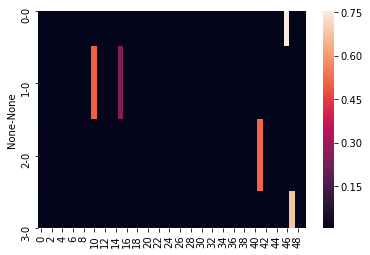

In [53]:
%matplotlib inline
sns.heatmap(panda_stack(vec2))

In [54]:
vec2

[      0      1      2      3      4      5      6      7      8      9   ...  \
 0  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  ...   
 
       40     41     42     43     44     45     46     47     48     49  
 0  0.005  0.005  0.005  0.005  0.005  0.005  0.755  0.005  0.005  0.005  
 
 [1 rows x 50 columns],
       0      1      2      3      4      5      6      7      8      9   ...  \
 0  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  ...   
 
       40     41     42     43     44     45     46     47     48     49  
 0  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  0.005  
 
 [1 rows x 50 columns],
      0     1     2     3     4     5     6     7     8     9   ...    40  \
 0  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  ...  0.01   
 
      41    42    43    44    45    46    47    48    49  
 0  0.51  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  
 
 [1 rows x 50 columns],
          0         

In [55]:
reduce(format_data(vec2), ndims=3, stack=True)

,,0,1,2
0,0,0.596817,0.146442,-0.039561
1,0,-0.131025,-0.374838,-0.310693
2,0,-0.099376,-0.197812,0.416569
3,0,-0.366417,0.426208,-0.066315


In [63]:
#note: doesn't work without specifying a marker-based line style.  should it?
plotter(vec2, 'o', reduce_kwargs={'ndims': 3})

In [57]:
#FIXME: this works, but should be the same as the previous cell
plotter(reduce(vec2, ndims=3), 'o')